# Python機器學習與深度學習入門 期末專題
### 組員 : 
* 統計碩一  周卉敏  R07H41003     
* 生工碩一  劉佳儀  R07622038

### 題目 : 圖型辨識 : 是否為動物

### 目標：利用CNN做圖型辨識

* 資料來源：[CIFAR_10](http://www.cs.toronto.edu/~kriz/cifar.html) (Canadian Institute For Advanced Research) dataset
- 資料內容：
    * 該資料集內含 10 類動物(鳥、貓、狗、青蛙…等)及非動物的圖像(共60000張，每張32X32)
    * 其中50000張為training images, 10000張為test images
- 目標1：
    * 輸入：32X32圖片；輸出：該照片屬於10類中哪一類，以各種方式增加模型的準確率
- 目標2：
    * 找新的測試照片測試模型，分析模型對於每個分類辨識所抓的特徵

- 資料集大致長相：

![](image/cifar_10_example.png)

 ## Cifar 10 資料集種類 :
- 0 : airplane
- 1 : automobile(car)
- 2 : bird
- 3 : cat
- 4 : deer
- 5 : dog
- 6 : frog
- 7 : horse
- 8 : ship
- 9 : truck

# 1. 初始準備

In [3]:
%env KERAS_BACKEND = tensorflow

env: KERAS_BACKEND=tensorflow


In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# load CIFAR10
import pickle
import re

# display
from ipywidgets import interact
from IPython.display import HTML, display

# keras
from keras.models import Model
from keras.layers import Input, Dense, Flatten, concatenate, Dropout, Activation
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Convolution2D
from keras.optimizers import SGD, Adam, Adadelta
from keras.utils import np_utils
from keras import backend as K
import keras.callbacks

# SqueezeNet
import h5py
from keras.layers import GlobalAveragePooling2D

# load models
from keras.models import model_from_json

# confusion matrix
import itertools 
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# opencv
import cv2

Using TensorFlow backend.


# 2. 將Google雲端硬碟中的資料讀取到 colab
參考資料 : [Can't read a file in google colaboratory](https://stackoverflow.com/questions/48967757/cant-read-a-file-in-google-colaboratory?fbclid=IwAR1tX0kaTatc6TkSs51dkYZB4zzZTfaFKhw2u0kes0OvLKwwZN_t6Jmf7ls)

In [ ]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null 
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

In [ ]:
# Generate auth tokens for Colab

from google.colab import auth
auth.authenticate_user()

In [ ]:
# Generate creds for the Drive FUSE library.

from oauth2client.client import GoogleCredentials 
creds = GoogleCredentials.get_application_default()
import getpass 
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass() 
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# 每次授權碼都不同，需重新點進去產生

In [ ]:
# Create a directory and mount Google Drive using that directory.

!mkdir -p drive
!google-drive-ocamlfuse drive

# 3. CIFAR 10 資料集
參考資料 : [How can l visualize cifar-10 data (RGB) using python matplotlib?](https://www.quora.com/How-can-l-visualize-cifar-10-data-RGB-using-python-matplotlib?fbclid=IwAR0p9oqBDfPeZWhHgyOYjoL9FJDn9Dc3o2GyEqmSXs6GJsrccWCERtAsUUU)
## 3.1 讀取資料
### 3.1.1 colab 讀取雲端 CIFAR10 資料集

資料集為由cPickle製成的pickle物件，用CIFAR10官方網站提供的unpickle函數打開

In [ ]:
def unpickle(file):
    with open(file, "rb") as fo:
        direc = pickle.load(fo, encoding='bytes')
    return direc

讀取CIFAR10中的60000張圖片，其中訓練圖片50000張，測試照片10000張

In [ ]:
df_train = pd.DataFrame()
train_y = pd.DataFrame()
 
for i in range(1,6):
    data = unpickle('drive/Colab Notebooks/data/cifar-10-batches-py/data_batch_' + str(i))
    df_train = df_train.append(pd.DataFrame(data[b'data']))
    train_y = train_y.append(pd.DataFrame(data[b'labels']))
    df_train['labels'] = train_y 

train_x = np.asarray(df_train.iloc[:, :3072])
train_y = np.asarray(df_train['labels'])
test_x = np.asarray(unpickle('drive/Colab Notebooks/data/cifar-10-batches-py/test_batch')[b'data'])
test_y = np.asarray(unpickle('drive/Colab Notebooks/data/cifar-10-batches-py/test_batch')[b'labels'])    
labels = unpickle('drive/Colab Notebooks/data/cifar-10-batches-py/batches.meta')[b'label_names']

### 3.1.2 jupyter notebook  讀取 CIFAR10 資料集

資料集為由cPickle製成的pickle物件，用CIFAR10官方網站提供的unpickle函數打開

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        direc = pickle.load(fo, encoding='bytes')
    return direc

讀取CIFAR10中的60000張圖片，其中訓練圖片50000張，測試照片10000張

In [5]:
df_train = pd.DataFrame()
train_y = pd.DataFrame()
 
for i in range(1,6):
    data = unpickle('data/cifar-10-batches-py/data_batch_' + str(i))
    df_train = df_train.append(pd.DataFrame(data[b'data']))
    train_y = train_y.append(pd.DataFrame(data[b'labels']))
    df_train['labels'] = train_y 

train_x = np.asarray(df_train.iloc[:, :3072])
train_y = np.asarray(df_train['labels'])
test_x = np.asarray(unpickle('data/cifar-10-batches-py/test_batch')[b'data'])
test_y = np.asarray(unpickle('data/cifar-10-batches-py/test_batch')[b'labels'])    
labels = unpickle('data/cifar-10-batches-py/batches.meta')[b'label_names']

## 3.2 整理資料並展示

利用interact展示訓練圖片

In [6]:
def plot_CIFAR(ind):
    arr = train_x[ind]
    R = arr[0:1024].reshape(32,32)/255.0
    G = arr[1024:2048].reshape(32,32)/255.0
    B = arr[2048:].reshape(32,32)/255.0
    
    img = np.dstack((R,G,B))
    name = str(labels[train_y[ind]])
    title = name[1:]
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)
    ax.imshow(img, interpolation='bicubic')
    ax.set_title('Category = '+ title, fontsize=12)

In [7]:
interact(plot_CIFAR, ind=(0,49999)) #共50000張

interactive(children=(IntSlider(value=24999, description='ind', max=49999), Output()), _dom_classes=('widget-i…

<function __main__.plot_CIFAR(ind)>

## 3.3 資料預處理

先將X標準化，使其值皆介於[0,1]之間

In [8]:
x_train0 = train_x.reshape(50000,32,32,3)
x_test0 = test_x.reshape(10000,32,32,3) 

x_train = x_train0/255
x_test = x_test0/255

In [14]:
print(x_train.min(), x_train.max(), x_test.min(), x_test.max())

0.0 1.0 0.0 1.0


In [15]:
# 1-hot encoding

y_train = np_utils.to_categorical(train_y,10)
y_test = np_utils.to_categorical(test_y,10)

# 4. 目標 1 ： 辨別 10 類圖片
## 4.1 測試 Activation Function
為了選出適合此資料集的 activation function ，將 activation function 分別進行測試，並且比較準確率。
### 4.1.1 測試所用的 Activation Function
1. tanh
2. softplus
3. softsign
4. elu
5. selu
6. relu
7. sigmoid
8. hard_sigmoid
9. exponential
10. linear

### 4.1.2 測試所用的模型
神經網路架構  :  2 層 CNN 接 2層 NN
- CNN 架構 :
    * 做 <span style="color:red;">2</span> 次 convolution, 每次都接 max-pooling
    * filter 大小都是 <span style="color:red;">5 x 5</span>, max-pooling 都用 <span style="color:red;">2 x 2</span> 為一小區塊
    * CNN 的 filters 數量分別是 <span style="color:red;">4, 8</span> 個

- 標準神經網路架構 :
    * 有 <span style="color:red;">2</span> 個隱藏層, 分別使用 <span style="color:red;"> 100, 50</span> 個神經元 
    * 最後一層為類別層，有 <span style="color:red;">10</span> 個神經元，Activation Function 為 <span style="color:red;">softmax</span>
 
- compile :
    * Loss function 使用 <span style="color:red;"> mse </span>
    * optimizer 使用 <span style="color:red;"> SGD </span>
    * learning rate 為 <span style="color:red;"> 0.7 </span>
    * 訓練<span style="color:red;"> 100 </span>筆資料 (`batch_size`)調一次參數
    * 共訓練<span style="color:red;"> 10 </span>次 (`epochs`)


以下為神經網路的架構圖

<img src="image/CNN_activation_function_test.png" width="800">

- $f_1, f_2, f_3, f_4, f_5$ 代表的是函數，說明如下 :
    * $f_1$ : convolution 有 4 個 5 x 5 的 filter ，padding 設成 same，表示每個 filter 會輸出原來 32 x 32  一樣大小的矩陣
    * pool1 : 2 x 2 為一小區塊的 max-pooling
    * $f_2$ : convolution 有 8 個 5 x 5 的 filter ，padding 設成 same，表示每個 filter 會輸出原來 32 x 32 一樣大小的矩陣
    * pool2 : 2 x 2 為一小區塊的 max-pooling
    * $f_3$ : NN 全連結層，有 100 個神經元
    * $f_4$ : NN 全連結層，有 50 個神經元
    * $f_5$ : NN 全連結層，有 10 個神經元，activation function 固定使用 softmax


- 變數說明如下 :
    * $x$ : 代表的是輸入模型的圖片向量，為 3072 維的向量。
    * $h_1$ : $x$ 經過第一層 convolution 以及 max-pooling 後得結果，即為 $pool1(f_1(x))$
    * $h_2$ : $h_1$ 經過第二層 convolution 以及 max-pooling 後得結果，即為 $pool2(f_2(h_1))$
    * $h_3$ : $h_2$ 先由 Flatten 拉平後，經過第一層隱藏層運算後得結果，即為 $f_3(h_2)$，為 100 維的向量
    * $h_4$ : $h_3$ 經過第一層隱藏層運算後得結果，即為 $f_4(h_3)$，為 50 維的向量    
    * $y$ : $h_4$ 經過最後一層運算後得結果，即為 $f_5(h_4)$，為 10 維的向量，代表的是 $x$ 為哪個種類照片的機率

In [60]:
# 函數

f1 = Conv2D(8,(5,5), padding = 'same', activation = 'selu') 
pool1 = MaxPool2D(pool_size = (2, 2))

f2 = Conv2D(16,(5,5), padding = 'same', activation = 'selu') 
pool2 = MaxPool2D(pool_size = (2, 2))

flatten = Flatten()

f3 = Dense(100, activation='tanh')     
f4 = Dense(50, activation='tanh')      
f5 = Dense(10, activation='softmax')   

In [61]:
# 變數

x = Input(shape = (32, 32, 3))
h1 = pool1(f1(x))
h2 = pool2(f2(h1))
h3 = f3(flatten(h2))
h4 = f4(h3)
y = f5(h4)

In [62]:
model = Model(x,y)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 8)         608       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 16)        3216      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               102500    
__________

In [63]:
model.compile(loss = 'mse', optimizer = SGD(lr=0.7), metrics=['accuracy']) 

In [ ]:
model_hist1 = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size = 100, epochs = 10)

### 4.1.3 測試 Activation Function的方式 
`測試方式 1` : $f_1, f_2, f_3, f_4$ 皆使用相同的 activation function

`測試方式 2`: CNN 所使用的 $f_1, f_2$ 用同一種 activation function，NN 所使用的 $f_3, f_4$ 用另一種相同的 activation function

測試後比較各種 activation function 的準確率

### 4.1.4 測試結果
#### 測試方式 1 : $f_1, f_2, f_3, f_4$ 皆使用相同的 activation function
* Rank : 排序方式依據訓練圖片的準確率

|Num.|Activation|Accuracy_train|Accuracy_test|loss_train|loss_test|Rank|
|:------:|:---------:|:-----------:|:------------:|:------:|:----:|:-----:|
|1|tanh        |0.556|0.524|0.058|0.061|2|
|2|softplus    |0.465|0.461|0.068|0.068|7|
|3|softsign    |0.512|0.497|0.063|0.064|5|
|4|relu        |0.512|0.493|0.063|0.064|6|
|5|sigmoid     |0.119|0.124|0.09 |0.09|8|
|6|selu        |0.565|0.528|0.057|0.06|1|
|7|elu         |0.553|0.539|0.059|0.06|3|
|8|hard_sigmoid|0.098|0.1  |0.09 |0.09|10|
|9|exponential |0.1  |0.1  |nan  |0.09|9|
|10|linear     |0.533|0.511|0.069|0.063|4|

將 activation function 依照編號分為 2 區塊，分別為 1~5, 6~10 ，取各區訓練資料準確率最高的前 3 名 activation function ，畫出歷史準確率，比較結果 :

<table><tr><td><img src='image/Activation_setting_1_1.png'></td><td><img src='image/Activation_setting_1_2.png'></td></tr></table>


* 由上左圖可以看出 selu 的準確率一直都是最高的，在訓練次數小於4次時， linear 會高於 elu ，訓練次數大於 4 次時，elu 的準確率逐漸比 linear 越來越高
* 由上右圖可以看出 tanh 的準確率一直都是最高的，訓練次數小於 8 時，relu 的準確率會高於 softsign ，而訓練次數大於 8 時，relu 及 softsign 的準確率相近

#### 測試方式 2 : CNN 所使用的 $f_1, f_2$ 用同一種 activation function，NN 所使用的 $f_3, f_4$ 用另一種相同的 activation function
* 依據測試方式1 所得到的測試結果，取出準確率最高的 4 個 activation functions (selu, elu, linear, tanh) 以及 relu，以測試方式兩兩組合列出判別準確率
* Rank : 排序方式依據訓練資料的準確率

|Num.|Activation|Accuracy_train|Accuracy_test|Rank|
|--------|----------------|----------------------|---------------------|-------|
|1| (selu, selu, elu, elu)        |0.573 |0.534|3 
|2| (elu, elu, selu, selu)        |0.559 |0.519|9 
|3|(selu, selu, linear, linear)   |0.543 |0.521|14 
|4|(linear, linear, selu, selu)   |0.571 |0.539|4 
|5|(elu, elu, linear, linear)     |0.540 |0.520|15 
|6|(linear, linear, elu, elu)     |0.565 |0.537|8 
|7|(tanh, tanh, selu, selu)       |0.569 |0.523|5
|8|(selu, selu, tanh, tanh)       |0.576 |0.524|2
|9|(tanh, tanh, elu, elu)         |0.552 |0.507|11
|10|(elu, elu, tanh, tanh)        |0.568 |0.530|6
|11|(tanh, tanh, linear, linear)  |0.550 |0.512|12
|12|(linear, linear, tanh, tanh)  |0.577 |0.532|1
|13| (selu, selu, relu, relu)     |0.567 |0.531|7 
|14| (relu, relu, selu, selu)     |0.514 |0.492|16 
|15|(elu, elu, relu, relu)        |0.548 |0.525|13 
|16|(relu, relu, elu, elu)        |0.508 |0.498|18 
|17|(linear, linear, relu, relu)  |0.555 |0.540|10 
|18|(relu, relu, linear, linear)  |0.513 |0.505|17 

<table><tr><td><img src='image/Activation_setting_2_1.png'></td><td><img src='image/Activation_setting_2_2.png'></td></tr></table>

* 由上左圖可以看出 selu_elu 和 linear_selu 的準確率不相上下，linear_elu 的準確率在訓練次數上升後才慢慢追上
* 由上右圖可以看出 selu_tanh 的準確率一直都是最高的，linear_tanh 和 tanh_selu 則是或有交錯

## 4.2 測試 Dropout
經過測試發現訓練次數 (epochs) 較多時，會有過度擬合訓練資料(overfitting)的情況，因此考慮加上 Dropout

### 4.2.1 測試模型設置
神經網路架構 : 2 層 CNN 接 2層 NN
- CNN 架構 :
    * 做 <span style="color:red;">2</span> 次 convolution, 每次都接 max-pooling
    * filter 大小都是 <span style="color:red;">5 x 5</span>, max-pooling 都用 <span style="color:red;">2 x 2</span> 為一小區塊
    * CNN 的 filters 數量分別是 <span style="color:red;">32, 64</span> 個
    * 使用 <span style="color:red;">Dropout</span> 後，接到標準神經網路
- 標準神經網路架構 :
    * 有 <span style="color:red;">2</span> 個隱藏層, 分別使用 <span style="color:red;"> 100, 50</span> 個神經元 
    * 最後一層為類別層，有 <span style="color:red;">10</span> 個神經元，Activation Function 為 <span style="color:red;">softmax</span>
 
- compile :
    * Loss function 使用 <span style="color:red;"> mse </span>
    * optimizer 使用 <span style="color:red;"> SGD </span>
    * learning rate 為 <span style="color:red;"> 0.7 </span>
    * 訓練<span style="color:red;"> 100 </span>筆資料 (`batch_size`)調一次參數
    * 共訓練<span style="color:red;"> 10 </span>次 (`epochs`)

以下為測試Dropout的架構圖，我們增加convolutional layer的filter數量，由(4,8)改為(32,64)

<img src="image/CNN_dropout_test.png" width="1000">

- $f_1, f_2, f_3, f_4, f_5$ 代表的是函數，說明如下 :
    * $f_1$ : convolution 有 32 個 5 x 5 的 filter ，padding 設成 same，表示每個 filter 會輸出原來 32 x 32  一樣大小的矩陣
    * pool1 : 2 x 2 為一小區塊的 max-pooling
    * $f_2$ : convolution 有 64 個 5 x 5 的 filter ，padding 設成 same，表示每個 filter 會輸出原來 32 x 32  一樣大小的矩陣
    * pool1 : 2 x 2 為一小區塊的 max-pooling
    * Dropout : 每輪權重更新時隨機選擇一定比例的節點拋棄
    * $f_3$ : NN 全連結層，有 100 個神經元
    * $f_4$ : NN 全連結層，有 50 個神經元
    * $f_5$ : NN 全連結層，有 10 個神經元，activation function 固定使用 softmax


- 變數說明如下 :
    * $x$ : 代表的是輸入模型的圖片向量，為 3072 維的向量。
    * $h_1$ : $x$ 經過第一層 convolution 以及 max-pooling 後得結果，即為 $pool1(f_1(x))$
    * $h_2$ : $h_1$ 經過第二層 convolution 以及 max-pooling 後得結果，即為 $pool2(f_2(h_1))$
    * $h_3$ : $h_2$ 先由 Flatten 拉平以及 Dropout 後，經過第一層隱藏層運算後得結果，即為 $f_3(h_2)$，為 100 維的向量
    * $h_4$ : $h_3$ 經過第一層隱藏層運算後得結果，即為 $f_4(h_3)$，為 50 維的向量    
    * $y$ : $h_4$ 經過最後一層運算後得結果，即為 $f_5(h_4)$，為 10 維的向量，代表的是 $x$ 為哪個種類照片的機率

In [64]:
# 函數
f1 = Conv2D(32,(5,5), padding = 'same', activation = 'selu') 
pool1 = MaxPool2D(pool_size = (2, 2))
f2 = Conv2D(64,(5,5), padding = 'same', activation = 'selu') 
pool2 = MaxPool2D(pool_size = (2, 2))
flatten = Flatten()
f3 = Dense(100, activation='tanh')     
f4 = Dense(50, activation='tanh')      
f5 = Dense(10, activation='softmax')   
drop = Dropout(0.25)

In [ ]:
# 變數
x = Input(shape = (32, 32, 3))
h1 = pool1(f1(x))
h2 = pool2(f2(h1))
h3 = f3(flatten(drop(h2)))
h4 = f4(h3)
y = f5(h4)

In [66]:
model = Model(x,y)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
__________

In [67]:
model.compile(loss = 'mse', optimizer = SGD(lr=0.7), metrics=['accuracy']) 

In [ ]:
model_hist2 = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size = 100, epochs = 10)

### 4.2.2 測試方式
根據測試 activation function 的結果，選出準確率前 4 名的組合方式 (linear_tanh, selu_tanh, selu_elu, linear_selu)，再分別加上不同比例的 Dropout 來測試模型。

### 4.2.3 測試結果
下表為 3 種 activation function 組合的模型，配合不同比例的 Dropout ，測試資料的準確率


|Dropout|linear_tanh|selu_tanh|selu_elu|linear_selu|
|:-----:|:---------:|:-------:|:------:|:------:|
|0.25|0.619|0.610|0.585|0.604
|0.3 |0.62 |0.614|0.615|0.6
|0.35|0.593|0.609|0.626|0.593
|0.4 |0.590|0.612|0.627|0.601
|0.45|0.581|0.584|0.593|0.601

由上表可看出，selu 接 elu 加上 0.4 的 Dropout 準確率最高 (0.627)

## 4.3 三層CNN模型

為了增加訓練資料以及測試資料的 accuracy，我們參考 Ian Goodfellow, Yoshua Bengio 以及 Aaron Courville 所著之 DEEP LEARNING 一書更改模型。  
該書的 Figure1.2 提到，在深度學習模型中，不同的 hidden layer 抓取的特徵不同，例如: 第一層可能抓到圖形的邊界(直線等)、第二層則可能抓到圖形的特定角落、輪廓(contour)，最後在第三層將這些特徵組合成不同的物件的某部分，並在 output 時識別該圖片中含有什麼物件(object)，於是我們將4.2節的模型修改為3層CNN模型。

以下為新的模型架構圖
<img src="image/CNN_structure_2_3x3.png" width="1000">

In [5]:
# 函數
f1 = Conv2D(32,(4,4), padding = 'same', activation = 'selu') 
pool1 = MaxPool2D(pool_size = (2, 2))
drop1 = Dropout(0.2)
f2 = Conv2D(64,(4,4), padding = 'same', activation = 'selu') 
pool2 = MaxPool2D(pool_size = (2, 2))
drop2 = Dropout(0.3) 
f3 = Conv2D(128,(4,4), padding = 'same', activation = 'selu')
pool3 = MaxPool2D(pool_size = (2, 2))
drop3 = Dropout(0.4)  
flatten = Flatten()
f4 = Dense(10, activation='softmax')

In [6]:
# 變數
x = Input(shape = (32, 32, 3))
h1 = drop1(pool1(f1(x)))
h2 = drop2(pool2(f2(h1)))
h3 = pool3(f3(h2))
y = f4(flatten(drop3(h3)))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
model = Model(x,y)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        1568      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        32832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 64)          0         
__________

In [8]:
model.compile(loss = 'mse', optimizer = SGD(lr=0.7), metrics=['accuracy']) 

In [9]:
ES = keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', verbose = 1, patience = 4)

In [ ]:
model_hist3 = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size = 100, epochs = 10, callbacks=[ES])

### 4.3.1 模型的準確率

此處我們設定兩種不同的模型

- model 1: convolutional layer filter 大小為 3$\times$3
- model 2: convolutional layer filter 大小為 4$\times$4

由於 model 2 訓練圖片及測試圖片的 accuracy 不相上下，所以我們決定取參數較少的 model 1 為我們的候選模型

### 4.3.2 10 種類別測試資料的準確率

以下為 model 2 搭配不同 dropout 的 accuracy
* activation : selu
* Filter : 4x4
* ES : early stop 函數，我們監控 validation data (即測試資料)的 accuracy，若 accuracy 在模型的訓練過程中下降次數在4次以內(patience = 4)，則繼續訓練;反之則停止訓練
* Rank : 依據測試資料的準確率排序

|Num.|Drop1|Drop2|Drop3|Accuracy_train|Accuracy_test|Rank|
|:------:|:---------:|:--------:|:--------:|:--------------------:|:-------------------:|:------:|
|1|0.1|0.2|0.3|0.7027|0.6379|10
|2|0.2|0.2|0.2|0.6768|0.6513|5
|3|0.2|0.3|0.3|0.6774|0.6520|4
|4|0.2|0.3|0.4|0.6873|0.6545|2
|5|0.2|0.4|0.4|0.6660|0.6692|1
|6|0.3|0.3|0.2|0.7004|0.6440|8
|7|0.3|0.3|0.3|0.6738|0.6411|9
|8|0.3|0.3|0.4|0.6637|0.6507|6
|9|0.4|0.3|0.2|0.6837|0.6531|3
|10|0.4|0.3|0.3|0.6650|0.6469|7
|11|0.4|0.4|0.4|0.5681|0.5678|11


我們接著將 selu, elu, linear 以及 tanh 搭配不同 dropout 計算測試圖片的 accracy，發現在 convolutional layer filter 大小為 (3,3) 時，activation function=tanh 的 accuracy 最高。於是我們將模型中的 activation function 由 selu 改為 <span style="color:red;"> tanh </span>，此模型以下稱 m1

# 5. SqueezeNet
為了提升模型的準確率，我們參考了老師建議的 SqueezeNet，以下為參考資料及範例程式碼的 GitHub。

* [SQUEEZENET: ALEXNET-LEVEL ACCURACY WITH
50X FEWER PARAMETERS AND <0.5MB MODEL SIZE](https://openreview.net/pdf?id=S1xh5sYgx&fbclid=IwAR1b6QNjz9gD4U0wRDIyeetNfVRTpamYIBPChdBe_u5WQ9sEPljJlbth0mc)
* [GitHub_squeezenet_demo](https://github.com/DT42/squeezenet_demo?fbclid=IwAR01ps0-7MAK5OHksAdPb6XFR-1k0V5Vm_0Mh8x-p_RCMTHUO_QuKM1Deo0)

## 5.1 使用Forrest N. Iandola et al. 之 SqueezeNet 模型

In [ ]:
x_train0 = train_x.reshape(50000,3,32,32) #將圖片維度改為 3x32x32
x_test0 = test_x.reshape(10000,3,32,32) 

x_train = x_train0/255
x_test = x_test0/255

In [70]:
def SqueezeNet(nb_classes, inputs=(3, 32, 32)):
    """ Keras Implementation of SqueezeNet(arXiv 1602.07360)
    @param nb_classes: total number of final categories
    Arguments:
    inputs -- shape of the input images (channel, cols, rows)
    """

    input_img = Input(shape=inputs)
    conv1 = Convolution2D(
        96, (7, 7), activation='tanh', kernel_initializer='glorot_uniform',
        strides=(2, 2), padding='same', name='conv1',
        data_format="channels_first")(input_img)
    maxpool1 = MaxPooling2D(
        pool_size=(3, 3), strides=(2, 2), name='maxpool1',
        data_format="channels_first")(conv1)
    fire2_squeeze = Convolution2D(
        16, (1, 1), activation='tanh', kernel_initializer='glorot_uniform',
        padding='same', name='fire2_squeeze',
        data_format="channels_first")(maxpool1)
    fire2_expand1 = Convolution2D(
        64, (1, 1), activation='tanh', kernel_initializer='glorot_uniform',
        padding='same', name='fire2_expand1',
        data_format="channels_first")(fire2_squeeze)
    fire2_expand2 = Convolution2D(
        64, (3, 3), activation='tanh', kernel_initializer='glorot_uniform',
        padding='same', name='fire2_expand2',
        data_format="channels_first")(fire2_squeeze)
    merge2 = Concatenate(axis=1)([fire2_expand1, fire2_expand2])

    fire3_squeeze = Convolution2D(
        16, (1, 1), activation='tanh', kernel_initializer='glorot_uniform',
        padding='same', name='fire3_squeeze',
        data_format="channels_first")(merge2)
    fire3_expand1 = Convolution2D(
        64, (1, 1), activation='tanh', kernel_initializer='glorot_uniform',
        padding='same', name='fire3_expand1',
        data_format="channels_first")(fire3_squeeze)
    fire3_expand2 = Convolution2D(
        64, (3, 3), activation='tanh', kernel_initializer='glorot_uniform',
        padding='same', name='fire3_expand2',
        data_format="channels_first")(fire3_squeeze)
    merge3 = Concatenate(axis=1)([fire3_expand1, fire3_expand2])

    fire4_squeeze = Convolution2D(
        32, (1, 1), activation='tanh', kernel_initializer='glorot_uniform',
        padding='same', name='fire4_squeeze',
        data_format="channels_first")(merge3)
    fire4_expand1 = Convolution2D(
        128, (1, 1), activation='tanh', kernel_initializer='glorot_uniform',
        padding='same', name='fire4_expand1',
        data_format="channels_first")(fire4_squeeze)
    fire4_expand2 = Convolution2D(
        128, (3, 3), activation='tanh', kernel_initializer='glorot_uniform',
        padding='same', name='fire4_expand2',
        data_format="channels_first")(fire4_squeeze)
    merge4 = Concatenate(axis=1)([fire4_expand1, fire4_expand2])
    maxpool4 = MaxPooling2D(
        pool_size=(3, 3), strides=(2, 2), name='maxpool4',
        data_format="channels_first")(merge4)

    fire5_squeeze = Convolution2D(
        32, (1, 1), activation='tanh', kernel_initializer='glorot_uniform',
        padding='same', name='fire5_squeeze',
        data_format="channels_first")(maxpool4)
    fire5_expand1 = Convolution2D(
        128, (1, 1), activation='tanh', kernel_initializer='glorot_uniform',
        padding='same', name='fire5_expand1',
        data_format="channels_first")(fire5_squeeze)
    fire5_expand2 = Convolution2D(
        128, (3, 3), activation='tanh', kernel_initializer='glorot_uniform',
        padding='same', name='fire5_expand2',
        data_format="channels_first")(fire5_squeeze)
    merge5 = Concatenate(axis=1)([fire5_expand1, fire5_expand2])

    fire6_squeeze = Convolution2D(
        48, (1, 1), activation='tanh', kernel_initializer='glorot_uniform',
        padding='same', name='fire6_squeeze',
        data_format="channels_first")(merge5)
    fire6_expand1 = Convolution2D(
        192, (1, 1), activation='tanh', kernel_initializer='glorot_uniform',
        padding='same', name='fire6_expand1',
        data_format="channels_first")(fire6_squeeze)
    fire6_expand2 = Convolution2D(
        192, (3, 3), activation='tanh', kernel_initializer='glorot_uniform',
        padding='same', name='fire6_expand2',
        data_format="channels_first")(fire6_squeeze)
    merge6 = Concatenate(axis=1)([fire6_expand1, fire6_expand2])

    fire7_squeeze = Convolution2D(
        48, (1, 1), activation='tanh', kernel_initializer='glorot_uniform',
        padding='same', name='fire7_squeeze',
        data_format="channels_first")(merge6)
    fire7_expand1 = Convolution2D(
        192, (1, 1), activation='tanh', kernel_initializer='glorot_uniform',
        padding='same', name='fire7_expand1',
        data_format="channels_first")(fire7_squeeze)
    fire7_expand2 = Convolution2D(
        192, (3, 3), activation='tanh', kernel_initializer='glorot_uniform',
        padding='same', name='fire7_expand2',
        data_format="channels_first")(fire7_squeeze)
    merge7 = Concatenate(axis=1)([fire7_expand1, fire7_expand2])

    fire8_squeeze = Convolution2D(
        64, (1, 1), activation='tanh', kernel_initializer='glorot_uniform',
        padding='same', name='fire8_squeeze',
        data_format="channels_first")(merge7)
    fire8_expand1 = Convolution2D(
        256, (1, 1), activation='tanh', kernel_initializer='glorot_uniform',
        padding='same', name='fire8_expand1',
        data_format="channels_first")(fire8_squeeze)
    fire8_expand2 = Convolution2D(
        256, (3, 3), activation='tanh', kernel_initializer='glorot_uniform',
        padding='same', name='fire8_expand2',
        data_format="channels_first")(fire8_squeeze)
    merge8 = Concatenate(axis=1)([fire8_expand1, fire8_expand2])

    maxpool8 = MaxPooling2D(
        pool_size=(3, 3), strides=(2, 2), name='maxpool8',
        data_format="channels_first")(merge8)
    fire9_squeeze = Convolution2D(
        64, (1, 1), activation='tanh', kernel_initializer='glorot_uniform',
        padding='same', name='fire9_squeeze',
        data_format="channels_first")(maxpool8)
    fire9_expand1 = Convolution2D(
        256, (1, 1), activation='tanh', kernel_initializer='glorot_uniform',
        padding='same', name='fire9_expand1',
        data_format="channels_first")(fire9_squeeze)
    fire9_expand2 = Convolution2D(
        256, (3, 3), activation='tanh', kernel_initializer='glorot_uniform',
        padding='same', name='fire9_expand2',
        data_format="channels_first")(fire9_squeeze)
    merge9 = Concatenate(axis=1)([fire9_expand1, fire9_expand2])

    fire9_dropout = Dropout(0.5, name='fire9_dropout')(merge9)
    conv10 = Convolution2D(
        nb_classes, (1, 1), activation='tanh', kernel_initializer='glorot_uniform',
        padding='valid', name='conv10',
        data_format="channels_first")(fire9_dropout)

    global_avgpool10 = GlobalAveragePooling2D(data_format='channels_first')(conv10)
    softmax = Activation("softmax", name='softmax')(global_avgpool10)

    return Model(inputs=input_img, outputs=softmax)

In [71]:
model = SqueezeNet(nb_classes=10)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 3, 32, 32)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 96, 16, 16)   14208       input_3[0][0]                    
__________________________________________________________________________________________________
maxpool1 (MaxPooling2D)         (None, 96, 7, 7)     0           conv1[0][0]                      
__________________________________________________________________________________________________
fire2_squeeze (Conv2D)          (None, 16, 7, 7)     1552        maxpool1[0][0]                   
__________________________________________________________________________________________________
fire2_expa

In [72]:
model.compile(loss = 'mse', optimizer = SGD(lr=0.7), metrics=['accuracy']) 

In [ ]:
model_hist4 = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size = 100, epochs = 150)

## 5.2 模型放入 Fire Module
### 5.2.1 Fire 模型架構
Fire 模型將原本一層的conv拆成兩層 (squeeze + expand)
- squeeze :
    * 全部的 filter 皆為 <span style="color:red;">1 x 1</span> 
   
- expand :
    * filter 分成 <span style="color:red;">1 x 1</span> 及 <span style="color:red;">3 x 3</span> 各一半
    * expand 兩個的 output 會連接起來

 
- compile :
    * Loss function 使用 <span style="color:red;"> mse </span>
    * optimizer 使用 <span style="color:red;"> SGD </span>
    * learning rate 為 <span style="color:red;"> 0.7 </span>
    * 訓練<span style="color:red;"> 100 </span>筆資料 (`batch_size`)調一次參數
    * 共訓練<span style="color:red;"> 150 </span>次 (`epochs`)

以下為 CNN + Fire module 的模型架構圖


<img src="image/CNN_fire.png" width="1200">

    1. convolution 有 64 個 (3,3) 的 filter，padding 設成 same，activation 使用 tanh
    2. Fire1
        * squeeze : 有 16 個 (1,1) 的 filter ，padding 設成 same，activation 使用 tanh
        * expand : 有 32 個 (1,1) 及 32 個 (3,3) 的 filter ，padding 設成 same
    3. Max-pooling_1 : (2,2) 為一小區塊的 max-pooling
    4. Dropout_1 : 每輪權重更新時隨機選擇 50% 的節點拋棄
    5. Fire2
        * squeeze : 有 32 個 (1,1) 的 filter ，padding 設成 same，activation 使用 tanh     
        * expand : 有 64 個 (1,1) 及 64 個 (3,3) 的 filter ，padding 設成 same
    6. Max-pooling_2 : (2,2) 為一小區塊的 max-pooling
    7. Dropout_2 : 每輪權重更新時隨機選擇 50% 的節點拋棄
    8. Fire3
        * squeeze : 有 64 個 (1,1) 的 filter ，padding 設成 same，activation 使用 tanh
        * expand : 有 128 個 (1,1) 及 128 個 (3,3) 的 filter ，padding 設成 same
    9. Max-pooling_3 : (2,2) 為一小區塊的 max-pooling
    10. Dropout_3 : 每輪權重更新時隨機選擇 50% 的節點拋棄
    11. Fire4
        * squeeze : 有 128 個 (1,1) 的 filter ，padding 設成 same，activation 使用 tanh
        * expand : 有 256 個 (1,1) 及 256 個 (3,3) 的 filter ，padding 設成 same
    12. Max-pooling_4 : (2,2) 為一小區塊的 max-pooling
    13. Dropout_4 : 每輪權重更新時隨機選擇 50% 的節點拋棄
    14. Flatten : 拉平資料
    15. NN 全連結層，有 10 個神經元，activation function 固定使用 softmax ，運算後的 output 為 10 維的向量，代表為哪個種類照片的機率

### 5.2.2 決定fire module參數
將上述模型架構，測試以下六種不同參數設定，epoch 皆為 150 次

* squeeze : 各 squeeze 層的 filter 數量
* expand : 各 expand 層的 filter 數量
* dropout : 每輪權重更新時隨機選擇拋棄的節點比例
* maxpooling : 進行 maxpooling 的次數

|model|squeeze|expand|dropout|maxpooling|Accuracy_train|Accuracy_test
|:---:|:-----:|:----:|:-----:|:--------:|:-----------:|:----------:|
|CNN_fire_1|(8, 16, 32, 32)|(32, 64, 128, 128)|(0.2, 0.3, 0.3, 0.4)|4|0.775|0.717
|CNN_fire_2|(8, 16, 32, 64)|(32, 64, 128, 256)|(0.2, 0.3, 0.4, 0.5)|4|0.777|0.714
|CNN_fire_3|(8, 16, 32, 64)|(32, 64, 128, 256)|(0.2, 0.3, 0.4, 0.5)|2|0.773|0.684
|CNN_fire_4|(16, 32, 64, 128)|(32, 64, 128, 256)|(0.2, 0.3, 0.4, 0.5)|4|0.801|0.734
|CNN_fire_5|(16, 32, 64, 128)|(32, 64, 128, 256)|(0.4, 0.4, 0.4, 0.4)|4|0.779|0.727
|CNN_fire_6|(16, 32, 64, 128)|(32, 64, 128, 256)|(0.5, 0.5, 0.5, 0.5)|4|0.729|0.713

<table><tr><td><img src='image/CNN_fire_1.png'></td><td><img 
src='image/CNN_fire_2.png'></td><td><img                                                       src='image/CNN_fire_3.png'></td></tr></table>
<table><tr><td><img 
src='image/CNN_fire_4.png'></td><td><img 
src='image/CNN_fire_5.png'></td><td><img                                                       src='image/CNN_fire_6.png'></td></tr></table>

由上表可知

1. 減少 maxpooling 次數容易造成 overfitting
2. CNN_fire_4 雖然測試資料的準確率最高，但從 history 中發現 overfitting 之現象，因此我們決定使用 overfitting 情況最輕微的 CNN_fire_6，並再訓練20次，此模型以下稱`m2`。

In [74]:
def fire_module(x,squeeze,expand,channel_axis):
    x = Conv2D(squeeze,(1,1),padding='same')(x)
    x = Activation('tanh')(x)
    left = Conv2D(expand,(1,1),padding='same')(x)
    left = Activation('tanh')(left)
    right = Conv2D(expand,(3,3),padding='same')(x)
    right = Activation('tanh')(right)
    x = concatenate([left, right],axis=channel_axis)
    return x

In [75]:
def squeezenet(img_input,classes=10):
    CONCAT_AXIS=3
    x = Conv2D(64, (3, 3), padding='same')(img_input)# valid
    x = Activation('tanh')(x)   
    x = fire_module(x,squeeze=16,expand=32,channel_axis=CONCAT_AXIS)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)    
    x = fire_module(x,squeeze=32,expand=64,channel_axis=CONCAT_AXIS)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)    
    x = fire_module(x,squeeze=64,expand=128,channel_axis=CONCAT_AXIS)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)    
    x = fire_module(x,squeeze=128,expand=256,channel_axis=CONCAT_AXIS)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)    
    x = Flatten()(x)
    out = Dense(classes, activation='softmax')(x)
    return out

In [76]:
img_input=Input(shape=(32,32,3))
output = squeezenet(img_input)
model=Model(img_input,output)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 64)   1792        input_4[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 64)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 16)   1040        activation_1[0][0]               
__________________________________________________________________________________________________
activation

In [77]:
model.compile(loss = 'mse', optimizer = SGD(lr=0.7), metrics=['accuracy']) 

In [ ]:
CNN_fire = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size = 100, epochs = 150)

# 6. `m1` & `m2` 模型結果比較

以下為本組報告所嘗試的三種不同模型: 

- `m1` : CNN, filters are 3 by 3
- `m2` : CNN_fire_6
- `m3` : SqueezeNet model

後續我們只針對`m1`和`m2`進行比較

## 6.1 `m1`, `m2` 及 `m3` accuracy 比較

下表為三種模型在訓練資料以及測試資料的accuracy

|model|Accuracy_train|Accuracy_test
|:---:|:-----------:|:----------:|
|$m_1$|0.741|0.705
|$m_2$|0.739|0.725
|$m_3$|0.916|0.725

由於 `m3` 模型 overfitting 情況較嚴重，故以下分析我們只針對前兩者進行

## 6.2 Confusion Matrix
為了比較 `m1` 以及 `m2` 在測試資料中不同類別的識別正確率(accuracy)，以下我們畫出 confusion matrix

讀取訓練好的模型

In [13]:
# m1
model1 = model_from_json(open('model/CNN_m1.json').read())
model1.load_weights('model/CNN_m1.h5')
model1.compile(loss = 'mse', optimizer = SGD(lr = 0.7), metrics=['accuracy'])

# m2
model2 = model_from_json(open('model/CNN_m2.json').read())
model2.load_weights('model/CNN_m2.h5')
model2.compile(loss = 'mse', optimizer = SGD(lr = 0.7), metrics=['accuracy'])

# SqueezeNet, 以下稱 m3
model3 = model_from_json(open('model/CNN_m3.json').read())
model3.load_weights('model/CNN_m3.h5')
model3.compile(loss = 'mse', optimizer = SGD(lr = 0.7), metrics=['accuracy'])

測試圖片判別的結果儲存在 predict 中

In [53]:
predict = model2.predict(x_test)

我們自訂一個`trans`函數，將模型輸出的 10 維向量(機率)轉換為對應 CIFAR10 的 10 種 ID

In [19]:
def trans(List):
    n = len(List)                               # Length of the input list 
    res = []                                    # Empty list for storing the ID
    for i in range(0,n):
        prob = List[i][0:10]
        index = np.where(prob == np.amax(prob)) # Find the position where the largest prob.
        res.append(index[0][0]+1)
    return(res)

In [54]:
y_test_id = trans(y_test)
y_pred_id = trans(predict)

下列的字典變數 Class 便為我們欲得到的 label，和 ID 一對一 mapping

In [27]:
# Create a dictionary
Class = {
    1: 'airplane',
    2: "automobile",
    3: "bird",
    4: "cat",
    5: "deer",
    6: "dog",
    7: "frog",
    8: "horse",
    9: "ship",
    10: "truck"
    }

In [55]:
# Prepare for confusion matrix
y_test_class = []
y_pred_class = []

for m in y_test_id:
    y_test_class.append(Class[m])

for k in y_pred_id:
    y_pred_class.append(Class[k])

以下為 `m1` 的 confusion matrix，對角線上的和為 7050，accuracy $=\dfrac{7050}{10000}=0.705$

In [56]:
y_True = y_test_class
y_Pred = y_pred_class

Classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

confusion_matrix(y_True, y_Pred, labels=Classes)

array([[749,  17,  38,  10,  15,  20,  30,  11,  88,  22],
       [ 10, 808,   0,   6,   7,  17,  20,   6,  36,  90],
       [ 53,   4, 536,  50,  83,  96, 136,  21,  13,   8],
       [ 18,   5,  47, 438,  55, 233, 134,  27,  22,  21],
       [ 10,   2,  54,  35, 659,  48, 131,  45,  14,   2],
       [  6,   4,  19,  95,  43, 711,  67,  37,  10,   8],
       [ 10,   0,  11,  36,  12,  23, 896,   2,   9,   1],
       [ 16,   2,  13,  23,  67,  82,  28, 752,   4,  13],
       [ 36,  21,   3,  11,   7,   4,   8,   3, 898,   9],
       [ 25,  56,   4,  15,   6,  15,  20,  12,  41, 806]], dtype=int64)

利用[參考資料](https://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix/)中的 plot_confusion_matrix，我們將 confusion matrix 加上類別(label)以及色塊顏色。

In [50]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black") 
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

<Figure size 432x288 with 0 Axes>

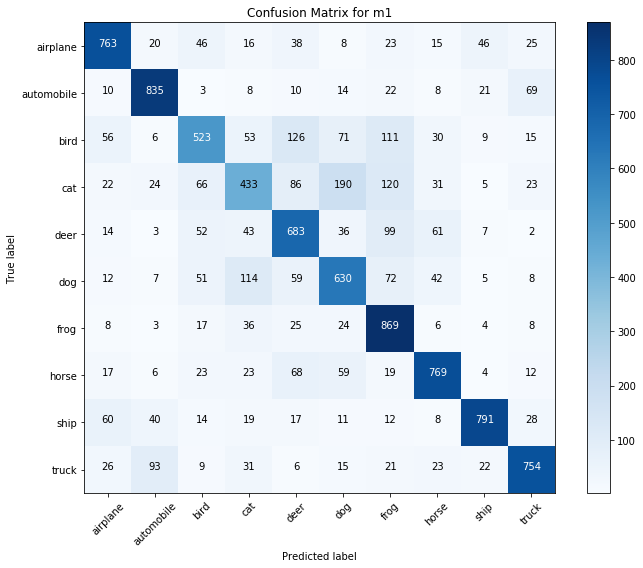

In [52]:
cnf_matrix = confusion_matrix(y_test_class, y_pred_class, labels=Classes)
np.set_printoptions(precision=2)

plt.figure()
plt.figure(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=Classes, title='Confusion Matrix for m1',cmap=plt.cm.Blues);

由上圖可以看出 `m1` 在判別 10 種不同類型時的正確率，橫軸是 `m1` 判別的 label，縱軸是測試資料真正的 label。  
我們發現下述類別有較嚴重之判別錯誤之情形:

   1. 有 114 張狗的圖片被判別成貓 
   2. 有 190 張貓的圖片被判別成狗; 另外有 120 張貓的照片被判別成青蛙
   3. 有 93 張卡車的圖片被判別成汽車
   4. 有 126 張鳥的圖片被判別成鹿; 另外有 111 張鳥的圖片被判別成青蛙
   5. 有 99 張鹿的圖片被判別成青蛙
    

以下我們如法炮製，畫出 `m2` 模型的 confusion matrix 並加上類別(label)及色塊顏色。`m2` 的 confusion matrix 對角線上的和為 7253，accuracy $=\dfrac{7253}{10000}=0.7253$

<Figure size 432x288 with 0 Axes>

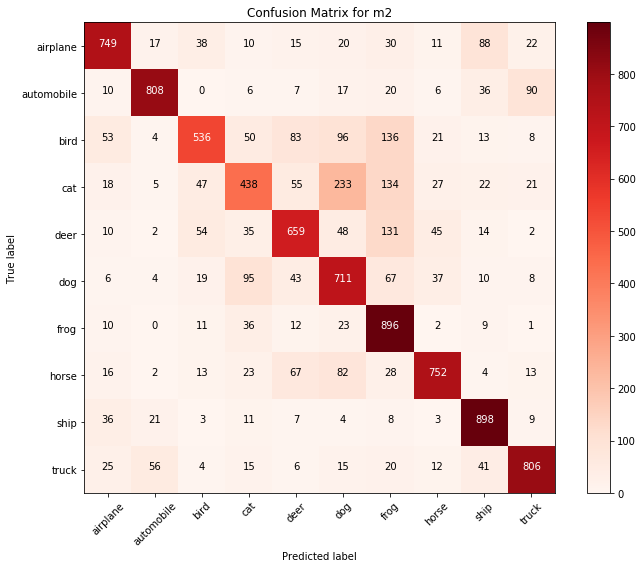

In [57]:
cnf_matrix = confusion_matrix(y_test_class, y_pred_class, labels=Classes)
np.set_printoptions(precision=2)

plt.figure()
plt.figure(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=Classes, title='Confusion Matrix for m2',cmap=plt.cm.Reds);

由上圖可以看出 `m2` 在判別 10 種不同類型時的正確率，橫軸是 `m2` 判別的 label，縱軸是測試資料真正的 label。  
我們發現下述類別有較嚴重之判別錯誤之情形:

   1. 有 88 張飛機的圖片被判別成船
   2. 有 90 張汽車的圖片被判別成卡車
   3. 有 96 張鳥的圖片被判別成狗; 另外有 136 張鳥的圖片被判別成青蛙
   4. 有 233 張貓的圖片被判別成狗; 另外有 134 張貓的圖片被判別成青蛙
   5. 有 131 張鹿的圖片被判別成青蛙
   6. 有 95 張狗的圖片被判別成貓
    

# 7. 目標 2： 以新的照片測試模型
利用 opencv 將在網路上找到的新照片處理後，用 `m1`, `m2` 及 `m3` 辨識類別，藉此分析不同模型抓取到的特徵。

- `m1` : CNN, filters are 3 by 3
- `m2` : CNN_fire_6
- `m3` : SqueezeNet model

## 7.1 `CNN_Prediction` 函數

我們自訂一個`CNN_Prediction`函數，輸入新找的圖片，利用 opencv 將其轉換成 32x32 pixel 之圖片，丟進三種模型中，最後輸出三種模型的判別結果以及其對應的機率。

In [14]:
def CNN_Prediction(img1):
    shape1 = img1.shape
    img2 = cv2.resize(img1, (32,32), interpolation=cv2.INTER_CUBIC)
    shape2 = img2.shape
    test_image0 = img2.reshape(1,32,32,3)
    test_image = test_image0/255
    predict1 = model1.predict(test_image)
    predict2 = model2.predict(test_image)
    predict3 = model3.predict(test_image)
    prob1 = predict1.max()
    prob2 = predict2.max()
    prob3 = predict3.max()
    Class = {
        1: 'airplane',
        2: "automobile",
        3: "bird",
        4: "cat",
        5: "deer",
        6: "dog",
        7: "frog",
        8: "horse",
        9: "ship",
        10: "truck"
    }
    ID1 = trans(predict1)[0]
    ID2 = trans(predict2)[0]
    ID3 = trans(predict3)[0]
    print("Shape of original image: %d x %d x %d" %shape1)
    print("Shape of reshaped image: %d x %d x %d" %shape2)
    print("Probability is %f" %prob1, prob2, prob3)
    print("This image is")
    return(Class[ID1], Class[ID2], Class[ID3])

舉例而言，若我們讀取下面這張卡車圖片
<img src="image/truck_3xFoSx_5.jpg" alt="Drawing" style="width: 600px;"/>

In [22]:
# 利用 cv2.imread 讀取上面的卡車圖片
img1 = cv2.imread('test_image/truck_3xFoSx_5.jpg')

In [20]:
CNN_Prediction(img1)

Shape of original image: 650 x 1000 x 3
Shape of reshaped image: 32 x 32 x 3
Probability is 0.721373 0.8411337 0.113082945
This image is


('cat', 'truck', 'cat')

由上述的輸出結果可知: 三個模型中，只有 `m2` 正確判別此張圖片為卡車，機率高達 0.84; `m1` 及 `m3` 判別為貓，機率分別為 0.72 及 0.11

## 7.2 照片判別結果比較

下述表格說明`m1`及`m2`在我們新找的照片中的判別結果

|model|airplane|automobile|bird|cat|deer|dog|frog|horse|ship|truck|
|:---:|:------:|:--------:|:--:|:-:|:--:|:-:|:--:|:---:|:--:|:---:|
|$m_1$ & $m_2$|o|x|o|o|o|x|o|x|o|o|
|$m_1$        |-|o|-|-|-|o|-|o|-|-|
|$m_2$        |-|x|-|-|-|o|-|x|-|-|

其中 o 表示有找到圖片; x 表示沒有找到圖片; - 表示省略

### 7.2.1 `m1` 及 `m2` 皆判斷正確的類別

<table><tr><td><img src='image/airplane_3oFoSx.jpg' alt="Drawing" style="width: 280px;"/></td><td>
<img src='image/bird_3oFoSx.jpg' alt="Drawing" style="width: 280px;"/></td><td>
<img src='image/cat_3oFoSo.jpg' alt="Drawing" style="width: 280px;"/></td></tr></table>

<table><tr><td><img src='image/deer_3oFoSx_2.jpg' alt="Drawing" style="width: 300px;"/></td><td>
<img src='image/frog_3oFoSx.jpg' alt="Drawing" style="width: 270px;"/></td><td>
<img src='image/ship_3oFoSx.jpg' alt="Drawing" style="width: 280px;"/></td><td>
<img src='image/truck_3oFoSx.jpg' alt="Drawing" style="width: 260px;"/></td></tr></table>

下表為 `m1`及`m2` 判斷三張圖片的機率，分別為 airplane, bird, cat, deer, frog, ship 以及 truck

|類別|airplane|bird|cat|deer|frog|ship|truck
|---|---------|----|----|----|---|----|-----
|m1  |    0.91|0.88|0.85|0.72|0.82|0.73|0.54
|m2  |    0.34|0.52|0.60|0.88|0.89|0.89|0.47

上面三張圖片兩種模型皆可正確辨認，我們推測`m1`模型和`m2`模型所抓取到的特徵類似，且`m1`機率幾乎都較高。  
(其中`m3`只能正確辨認貓咪的圖片)

### 7.2.2 只有 `m1` 判斷正確的類別

### 汽車

<table><tr><td><img src='image/car_3oFxSo.jpg' alt="Drawing" style="width: 250px;"/></td><td>
<img src='image/car_3oFxSx_3.jpg' alt="Drawing" style="width: 300px;"/></td><tr></table>

- 左圖: `m1`判別為車的機率為 0.86 (註: `m2` 判別左圖為卡車，機率 0.71) 
- 右圖: `m1`判別為車的機率為 0.82 (註: `m2` 判別右圖為卡車，機率 0.46) 

我們發現`m1`(CNN, filter 3 by 3) 在辨識汽車的結果比`m2`(fire model) 好，在測試新圖片時，`m2`往往會將汽車誤判成卡車，我們推測 fire model 中的 squeeze 層抓取的特徵過於細節，導致未辨認出汽車整體的輪廓，只注重卡車車頭形狀，所以判別表現較差。


### 馬

<table><tr><td><img src='image/horse_3oFxSx.jpg' alt="Drawing" style="width: 250px;"/></td><td>
<img src='image/horse_3oFxSx_2.jpg' alt="Drawing" style="height: 190px;"/></td><tr></table>

- 左圖: `m1`判別為馬的機率為 0.32 (註: `m2` 判別左圖為卡車，機率 0.43) 
- 右圖: `m1`判別為馬的機率為 0.29 (註: `m2` 判別右圖為鹿，機率高達 0.76)

我們發現`m1`在辨識馬匹的結果比`m2`好，在測試新圖片時，`m2`往往會將馬匹誤判成鹿，我們推測 fire model 中的 squeeze 層抓取的特徵過於細節，導致未辨認出馬匹的輪廓，所以判別表現較差。


### 7.2.3 狗的圖片判別結果

<table><tr><td><img src='image/dog_3oFxSx_2.jpg' alt="Drawing" style="width: 250px;"/></td><td>
<img src='image/dog_3xFoSx.jpg' alt="Drawing" style="width: 190px;"/></td><tr></table>

- 左圖: `m1`判別為狗的機率為 0.41 (註: `m2` 判別左圖為卡車，機率 0.89) 
- 右圖: `m2`判別為狗的機率為 0.58 (註: `m1` 判別右圖為貓，機率高達 0.67)

因為在測試新圖片時，`m2`將左圖的狗誤判成卡車；而`m1`將右圖的狗判別為貓，是比較接近的物件 (object)，由此例可看出`m1`在判別狗狗的圖片上表現較`m2`好。

# 8. 結論

首先我們比較`m1`及`m2`在 10 種類別辨識的 accuracy，由下圖可以看出，`m2`在測試圖片的 accuracy 較`m1`為佳。

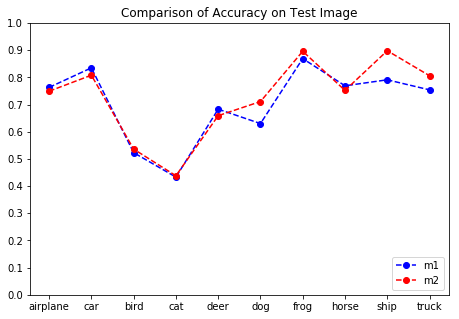

In [43]:
plt.figure(figsize=[7.5,5], facecolor='white')

x = ['airplane','car','bird','cat','deer','dog','frog','horse','ship','truck']
y1 = [0.763, 0.835, 0.523, 0.433, 0.683, 0.630, 0.869, 0.769, 0.791, 0.754]
y2 = [0.749, 0.808, 0.536, 0.438, 0.659, 0.711, 0.896, 0.752, 0.898, 0.806]
plt.plot(x, y1, label = "m1", c='b', linestyle='dashed', marker='o')
plt.plot(x, y2, label = "m2", c='r', linestyle='dashed', marker='o')

plt.legend(loc = "lower right")
new_yticks = np.linspace(0, 1, 11)
plt.yticks(new_yticks)
plt.title("Comparison of Accuracy on Test Image")
plt.show()

然而，從第 7 節加入新測試圖片的分析當中，我們發現:

1. `m1`在辨識 airplane, bird, cat, deer, frog, ship 以及 truck 這 7 項類別中，多達 5 種判別的機率較`m2`高
2. `m1`在辨識 car 及 horse 的辨識當中，皆勝過`m2`
3. `m1`在辨識 dog 時，雖然有判別錯的可能，但是其判斷為貓，貓本身與狗較為相似；`m2`卻直接判錯成卡車

總結以上三點，`m1`雖然在建模過程中，對測試圖片的 accuracy 不如`m2`，其本身對於新加入的照片判斷卻更準確。

從第 6.2 節的兩張 confusion matrix 中，我們發現:

1. cat 的 accuracy 最低，且常與 dog 搞混
2. frog 常與 bird 搞混
3. automobile 常與 truck 搞混
4. deer 常與 horse 搞混 (相較於前述三項輕微)

由第 7 節的測試分析，我們發現`m2`常將汽車辨識為卡車，以及將馬辨識為鹿；`m1`反而都成功辨識出卡車及馬。我們推測原因在於`m2`的 squeeze 中大小為 1x1 的 filter 抓取過多不必要的細節為特徵，CIFAR10 資料集的照片大小皆只有 32x32 pixel，解析度亦較低，故用來訓練模型的訓練圖片皆較為模糊，判別不同類別可能只需根據輪廓就能判別地很準，不需要過多細節，導致 `m1` (filter 大小為 3x3) 在分類上表現都優於`m2`。若用於訓練的圖片解析度較高，或許會有不同的結果。